## pgmuvi

In [1]:
import os, sys
sys.path.insert(0,'/Users/jamal/Documents/GitHub/pgmuvi/pgmuvi')
mdir = os.getcwd()


In [2]:
import pgmuvi

import pgmuvi.trainers as trainers
import pgmuvi.lightcurve as lightcurve
import pgmuvi.test_script as test_script
import pgmuvi.gps as gps

1564
Initial z-scaled period:  0.019876517860690286
Initial period:  tensor(400.)
Inital width:  tensor(7.9506)
Initial weight:  1.0
Additional noise:  0.10000001639127731
<generator object Module.parameters at 0x7fc1a6e110d0>
Parameter containing:
tensor([0.5878], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)
Parameter containing:
tensor([0.5413], requires_grad=True)
Parameter containing:
tensor([[[50.3106]]], requires_grad=True)
Parameter containing:
tensor([[[0.5413]]], requires_grad=True)
Parameter name: likelihood.noise_covar.raw_noise           value = tensor([0.5878])
Parameter name: mean_module.constant                       value = tensor([0.])
Parameter name: covar_module.raw_mixture_weights           value = tensor([0.5413])
Parameter name: covar_module.raw_mixture_means             value = tensor([[[50.3106]]])
Parameter name: covar_module.raw_mixture_scales            value = tensor([[[0.5413]]])


100%|██████████| 300/300 [01:08<00:00,  4.36it/s]


loss
[0.7860513925552368, 0.4346226453781128, 0.19727811217308044, 0.0568777397274971, -0.019325509667396545, -0.057185180485248566, -0.07792261987924576, -0.0905083492398262, -0.08681056648492813, -0.08288722485303879, -0.06589119881391525, -0.06493508070707321, -0.06563074141740799, -0.0744297206401825, -0.10184308886528015, -0.12314646691083908, -0.1672532707452774, -0.20672622323036194, -0.23635029792785645, -0.25876471400260925, -0.28149688243865967, -0.30962619185447693, -0.3604957163333893, -0.3485183119773865, -0.36854058504104614, -0.372432142496109, -0.4024011194705963, -0.3799791932106018, -0.39059901237487793, -0.4136834144592285, -0.41164225339889526, -0.45120754837989807, -0.4872206151485443, -0.4887162148952484, -0.49146562814712524, -0.48582273721694946, -0.5228409767150879, -0.4891442358493805, -0.4826543927192688, -0.5143990516662598, -0.5493229031562805, -0.5016940832138062, -0.48470649123191833, -0.4965813159942627, -0.5129309296607971, -0.4625544548034668, -0.48097

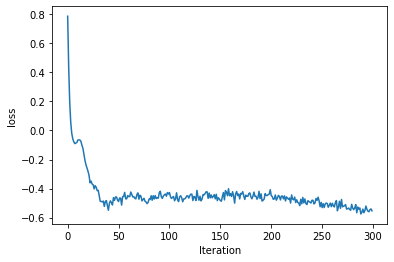

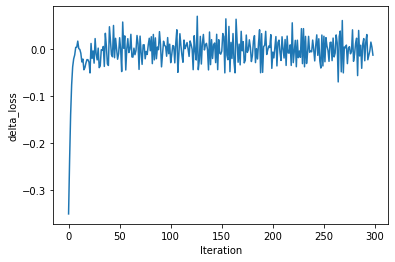

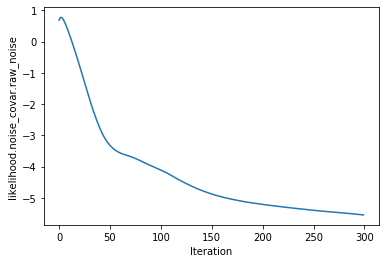

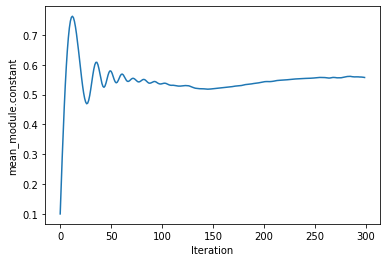

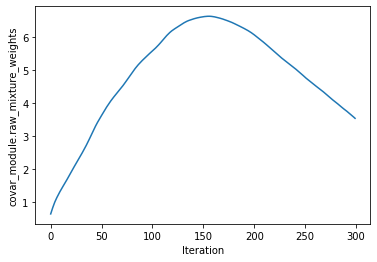

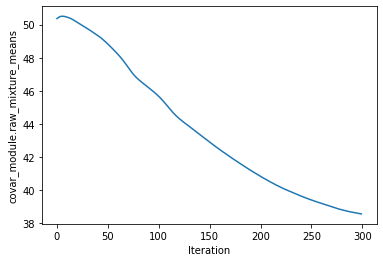

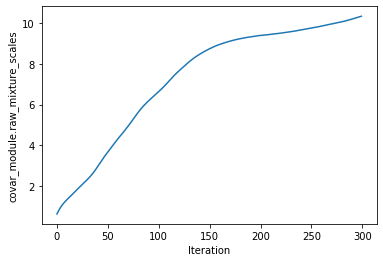

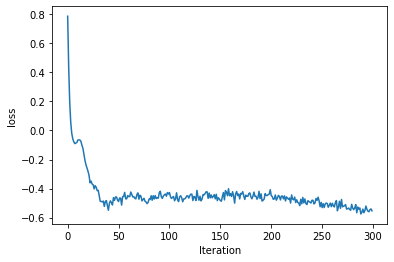

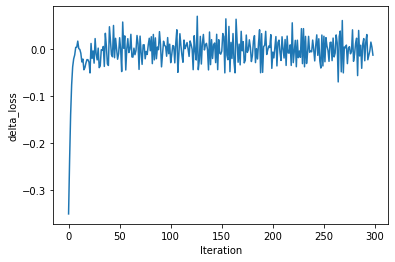

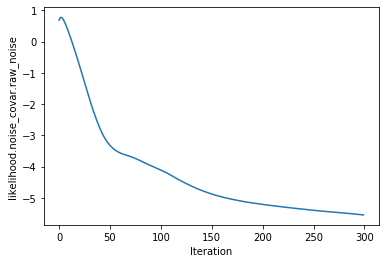

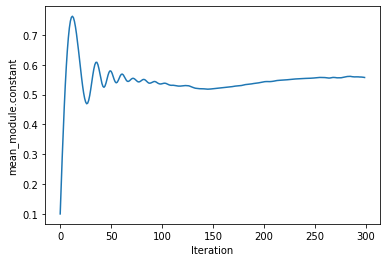

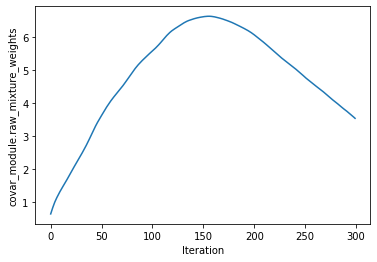

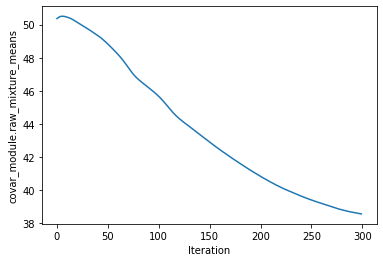

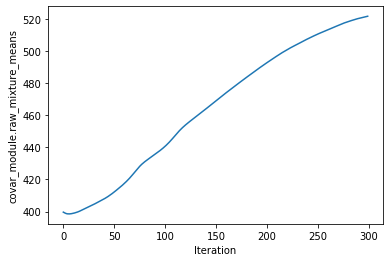

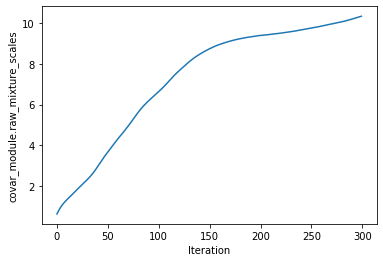

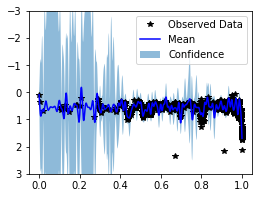

In [3]:
LCfile=mdir+"/../dataset/AlfOriAAVSO_Vband.csv"
test_script.run_pgmuvi(LCfile=LCfile)

## Local tests

In [7]:
%run ./pgmuvi/test_script

In [ ]:
print('Versions\n',
      '  gpytorch :', gpytorch.__version__, '\n',
      '  torch    :',torch.__version__)

In [23]:
timecolumn = 'JD'
magcolumn  = 'Magnitude'

testdata   = pd.read_csv(LCfile)

train_jd   = torch.Tensor(testdata[timecolumn].to_numpy())
train_mag  = torch.Tensor(testdata[magcolumn].to_numpy())

train_mag_err = 0.05*train_mag

period_guess = 400.

likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=Interval(0.01, 0.15))
n_mix = 1


In [24]:
date_range = torch.max(train_jd) - torch.min(train_jd)
train_jd   = train_jd - torch.min(train_jd)
train_jd   = train_jd/torch.max(train_jd)

In [25]:
#model = SMKG(train_jd, train_mag, likelihood, num_mixtures = n_mix, grid_size=4000)
model  = SMG(train_jd, train_mag, likelihood, num_mixtures = n_mix)

In [31]:
train_method="VI" #False #"NUTS"

#model.covar_module.base_kernel.raw_mixture_means.item = torch.Tensor([[[np.log10(1/100)]]])

In [32]:
#Now we should z-scale it
period_guess = period_guess/date_range

In [33]:
hypers = {
    'likelihood.noise_covar.noise': torch.tensor(0.2),
    'covar_module.base_kernel.raw_mixture_means': (1/period_guess.clone().detach()),
    'covar_module.base_kernel.raw_mixture_weights': torch.tensor(0.0),
    'covar_module.base_kernel.raw_mixture_scales': torch.tensor(0.),
    'mean_module.constant': torch.tensor(0.),
}

hypers = {
    'likelihood.noise_covar.noise': torch.tensor(0.2),
    'covar_module.raw_mixture_means': (1/period_guess.clone().detach()), #torch.tensor(-2.),
    'covar_module.raw_mixture_weights': torch.tensor(0.),
    'covar_module.raw_mixture_scales': torch.tensor(0.),
    'mean_module.constant': torch.tensor(0.),
}

hypers = {
    'likelihood.noise_covar.noise': torch.tensor(0.1),
    'covar_module.mixture_means'  : (1/period_guess.clone().detach()), #torch.tensor(-2.),
    'covar_module.mixture_weights': torch.tensor(1.),
    'covar_module.mixture_scales' : torch.tensor(1.),
    'mean_module.constant'        : torch.tensor(0.),
}

model.initialize(**hypers)

print("Initial z-scaled period: ", \
      1./(model.sci_kernel.mixture_means.item())) #for a single component
print("Initial period: ", \
      date_range * 1./(model.sci_kernel.mixture_means.item())) #for a single component
print("Inital width: ", \
      (model.sci_kernel.mixture_scales.item()/model.sci_kernel.mixture_means.item())*\
      (date_range/(model.sci_kernel.mixture_means.item())))
print("Initial weight: ", \
      model.sci_kernel.mixture_weights.item())
print("Additional noise: ", \
      model.likelihood.noise_covar.noise.item())


Initial z-scaled period:  9.87689865629115e-07
Initial period:  tensor(0.0199)
Inital width:  tensor(1.9632e-08)
Initial weight:  1.0
Additional noise:  0.10000001639127731


### training 

In [40]:
train_method

'VI'

In [38]:
P = period_guess
############################## NUTS ##############################
if train_method=="NUTS":
    cuda = False #Change this to True if you have access to a GPU
    if cuda:
        likelihood.cuda()
        model.cuda()

    num_samples = 100
    warmup_steps= 100
    model.mean_module.register_prior ("mean_prior",    UniformPrior(-1, 1),      "constant")
    model.covar_module.register_prior("means_prior",   LogNormalPrior(1/P, 0.1), "mixture_means")
    model.covar_module.register_prior("weights_prior", UniformPrior(0,1),        "mixture_weights")
    model.covar_module.register_prior("scales_prior",  UniformPrior(0,1/P),      "mixture_scales")
    #model.covar_module.base_kernel.register_prior("lengthscale_prior", UniformPrior(0.01, 0.5), "lengthscale")
    #model.covar_module.register_prior("outputscale_prior", UniformPrior(1, 2), "outputscale")
    likelihood.register_prior("noise_prior", UniformPrior(0.01, 0.15), "noise")

    def pyro_model(x, y):
        with gpytorch.settings.fast_computations(False, False, False):
            sampled_model = model.pyro_sample_from_prior()
            #help(sampled_model)
            output = sampled_model.likelihood(sampled_model(x))
            pyro.sample("obs", output, obs=y)
        return y

    jit = False
    nuts_kernel = NUTS(pyro_model, adapt_step_size=True, jit_compile=jit)
    mcmc_run    = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, disable_progbar=False)
    if cuda:
        mcmc_run.run(train_jd.cuda(), train_mag.cuda())
    else:
        mcmc_run.run(train_jd, train_mag)

    print(mcmc_run.summary(prob=0.5))

    model.pyro_load_from_samples(mcmc_run.get_samples())

    exit()

############################## VI ##############################
elif train_method=="VI":
    cuda = False #Change this to True if you have access to a GPU
    if cuda:
        likelihood.cuda()
        model.cuda()

    num_samples = 100
    warmup_steps= 100
    model.mean_module.register_prior ("mean_prior",     UniformPrior(-1, 1),      "constant")
    model.covar_module.register_prior("means_prior",    LogNormalPrior(1/P, 0.1), "mixture_means")
    model.covar_module.register_prior("weigthts_prior", UniformPrior(0,1),        "mixture_weights")
    model.covar_module.register_prior("scales_prior",   UniformPrior(0,1/P),      "mixture_scales")
    #model.covar_module.base_kernel.register_prior("lengthscale_prior", UniformPrior(0.01, 0.5), "lengthscale")
    #model.covar_module.register_prior("outputscale_prior", UniformPrior(1, 2), "outputscale")
    likelihood.register_prior("noise_prior", UniformPrior(0.01, 0.5), "noise")

    def pyro_model(x, y):
        with gpytorch.settings.fast_computations(False, False, False):
            sampled_model = model.pyro_sample_from_prior()
            #help(sampled_model)
            output = sampled_model.likelihood(sampled_model(x))
            pyro.sample("obs", output, obs=y)
        return y

    def pyro_guide(x,y):
        pass

############################################################
else:
    model.train()
    likelihood.train() 
    
    #help(likelihood)

    training_iter = 300#0

    print(model.parameters())
    for p in model.parameters():
        print(p)

    for param_name, param in model.named_parameters():
        print(f'Parameter name: {param_name:42} value = {param.data}')

    with gpytorch.settings.max_cg_iterations(10000):
        results = train(model, likelihood, train_jd, train_mag, maxiter = training_iter, miniter = 50, stop = 0.00001, lr=0.1, optim="AdamW", stopavg=30)


AssertionError: Torch not compiled with CUDA enabled

In [39]:
for key, value in results.items():
    print(key)
    print(value)
    try:
        print(value[0].size())
    except:
        pass
plot_results(results)

NameError: name 'results' is not defined